## Get Cuda and Processor information

In [1]:
import sys
sys.path.append('../Submodular')

import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

NUM_PROCESSORS

40

In [2]:
import multiprocessing

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

Cpu count:  40


In [3]:
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Dataset import datasets as available_datasets
from ipynb.fs.full.Utils import save_plot

In [4]:
import argparse
from argparse import ArgumentParser

#set default arguments here
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--recompute', type=bool, default=False)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Cora", choices=available_datasets)
    parser.add_argument('--use_normalization', action='store_false', default=True)
    parser.add_argument('--f') ##dummy for jupyternotebook
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

## libraries

In [5]:
import random
import numpy as np
import torch

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
None

In [6]:
import os
import math
import time
from tqdm import tqdm
import torch.nn as nn
from torch_geometric.data import Data, Dataset

## GNN model

In [7]:
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, ChebConv
from torch_geometric.nn import GraphConv, TransformerConv
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from ipynb.fs.full.SpatialConv import SpatialConv

### GNN option 1

In [8]:
GNNconv = SAGEConv

In [9]:
class GNNHomophily(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16):
        super().__init__()
        self.num_classes = num_classes
             
        self.conv1 = GNNconv(num_features, hidden_channels)
        #self.conv2 = GNNconv(hidden_channels,hidden_channels)
        self.conv3 = GNNconv(hidden_channels,num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        
        return x
    
class GNNHeterophily(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16):
        super().__init__()
        self.num_classes = num_classes
             
        self.conv1 = ChebConv(num_features, hidden_channels, K=2, normalization='sym')
        #self.conv2 = GNNconv(hidden_channels,hidden_channels)
        self.conv3 = ChebConv(hidden_channels,num_classes, K=2, normalization='sym')

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        
        return x
    
class AGSGNN(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16, dropout=0.5):
        super().__init__()
        self.num_classes = num_classes
        
        hidden = int(hidden_channels/2)
        
        #self.gnn1 = GNNHomophily(num_features, num_classes, hidden_channels)        
        self.gnn1 = GNNHomophily(num_features, hidden, hidden_channels)
        self.gnn2 = GNNHeterophily(num_features, hidden, hidden_channels)
        self.p = dropout
        self.com_lin = nn.Linear(hidden*2, num_classes)
        
        
#         self.T = 2        
#         self.layer_norm_a1 =  nn.LayerNorm(num_classes)
#         self.layer_norm_s1 =  nn.LayerNorm(num_classes)
        
#         self.alpha_a1 = nn.Linear(num_classes, 1)
#         self.alpha_s1 = nn.Linear(num_classes, 1)
#         self.w1 = nn.Linear(self.T, self.T)
        
        #self.reset_parameters()
            
#     def reset_parameters(self):
#         std_att = 1. / math.sqrt(self.w1.weight.size(1))
#         std_att_vec = 1. / math.sqrt( self.alpha_a1.weight.size(1))
        
#         self.alpha_s1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_i1.weight.data.uniform_(-std_att, std_att)
        
#         self.layer_norm_a1.reset_parameters()
#         self.layer_norm_s1.reset_parameters()        
        
    def forward(self, batch_data):
        
        #out = model(batch_data.x, batch_data.edge_index, batch_data.weight)
        #out = model(batch_data.x, batch_data.edge_index, batch_data.edge_weight)
        #out = model(batch_data.x, batch_data.edge_index)
        
        x1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index)
        #return x1        
        
        x2 = self.gnn2(batch_data[1].x, batch_data[1].edge_index)
        #return x2
        
        a1 = F.relu(x1)
        #a1 = self.layer_norm_a1(a1)
        a1 = F.dropout(a1, p=self.p, training=self.training)
        
        s1 = F.relu(x2)
        #s1 = self.layer_norm_s1(s1)
        s1 = F.dropout(s1, p=self.p, training=self.training)
        
        used = batch_data[0].batch_size
        
        x = torch.cat([a1[:used,:], s1[:used,:]], dim=-1)
        x = self.com_lin(x)
        
        
#         ala1 = torch.sigmoid(self.alpha_a1(a1))
#         als1 = torch.sigmoid(self.alpha_s1(s1))        
        
#         alpha1 = F.softmax(self.w1(torch.cat([ala1, als1],dim=-1)/self.T), dim=1)                
#         x = torch.mm(torch.diag(alpha1[:,0]),a1) + torch.mm(torch.diag(alpha1[:,1]),s1)
        
        #print(x.shape)
        
        return x

## GNN Training and Testing

In [10]:
from torch_geometric.loader import NeighborSampler, NeighborLoader
from ipynb.fs.full.AGSNodeSampler import WeightedNeighborLoader

In [11]:
def test(model, loader, mask, name='Train'):    
    if args.log_info:    
        pbar = tqdm(total=sum(mask).item())
        pbar.set_description(f'Evaluating {name}')
    
    model.eval()
    
    total_correct=0
    total_examples=0
    
    sigmoid = nn.Sigmoid()    
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():                  
    
        for i,batch_data in enumerate(loader):
            
            batch_data = [b.to(device) for b in batch_data]
            used = batch_data[0].batch_size
            
            out = model(batch_data)
                   
            out=out[:used,:]
            pred = out.argmax(dim=1)            

            y_true.append(batch_data[0].y[:used].detach().cpu().numpy())
            y_pred.append(pred.detach().cpu().numpy())
            
            if args.log_info:
                pbar.update(used)
              
    if args.log_info:
        pbar.close()
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
                    
    return acc

In [12]:
def train(DATASET_NAME, model, data, epochs=100, train_neighbors=[-1,10], test_neighbors=[-1,10]):
    
    if args.log_info:
        print("Train neighbors: ", train_neighbors)
        print("Test neighbors: ", test_neighbors)
        
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    optimizer = torch.optim.Adam(model.parameters())
    
    if data.y.ndim == 1:
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.BCEWithLogitsLoss()
    
    #batch_size=1024         
    batch_size=512         
    worker = 0
    
    if data.num_nodes>=50000:
        worker = 8
    else:
        worker = min(8,int(sum(data.train_mask)/batch_size))
        
    if args.log_info:
        print("Worker: ", worker)
        
#     weight_func=['knn','submodular']; 
    weight_func=['knn','submodular']; 
#     weight_func=['random', 'random'];  worker = 0;
#     weight_func=['link-nn', 'link-sub'];  worker = 2;
    params={
        'knn':{'metric':'cosine'},
        'submodular':{'metric':'cosine'},
        'link-nn':{'value':'min'},
        'link-sub':{'value':'max'},
    }    
    
    sampler_dir = DIR+'AGSGNNstruc/'+DATASET_NAME
#     if not os.path.exists(sampler_dir):
#         os.makedirs(sampler_dir)
    
    start = time.time()    
    loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                              batch_size=batch_size, shuffle=True, num_workers=worker, drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info,
                                    directed=True, replace = False,
                                    save_dir = sampler_dir,recompute = args.recompute)

    train_loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=worker, drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info,
                                          directed=True, replace = False,
                                          save_dir = sampler_dir,recompute = False)
    
    val_loader = WeightedNeighborLoader(data, input_nodes=data.val_mask,num_neighbors=test_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=min(8,int(sum(data.val_mask)/batch_size)), drop_last=False, 
                              weight_func=weight_func, params=params,log=args.log_info, directed=True, replace = False,
                                        save_dir = sampler_dir,recompute = False)
    
    test_loader = WeightedNeighborLoader(data, input_nodes=data.test_mask,num_neighbors=test_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=min(8,int(sum(data.test_mask)/batch_size)), drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info, directed=True, replace = False,
                                         save_dir = sampler_dir,recompute = False)
    
    top_k_accs = []    
    best_acc=0  
    
    train_losses=[]
    val_accuracies=[]
    train_accuracies=[]
    test_accuracies=[]
    
    num_iteration = epochs
    
    end = time.time()
    if args.log_info:
        print("Total initialization time: ", end-start)
    
    start = time.time()
    
    for epoch in range(1,epochs+1):
        
        if args.log_info:
            pbar = tqdm(total=int(sum(data.train_mask)))
            pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()
        total_loss = total_examples = 0
        
        for i,batch_data in enumerate(loader):            
            #print(batch_data)
            
            batch_data = [b.to(device) for b in batch_data]
            used = batch_data[0].batch_size #int(sum(batch_data.train_mask))       
            
            optimizer.zero_grad()            
            out = model(batch_data)
            #out = F.log_softmax(out, dim=1)                 
            #loss = F.nll_loss(out[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask])
            #loss = F.cross_entropy(out[:used], batch_data[0].y[:used])
            loss = criterion(out[:used], batch_data[0].y[:used])
            
            loss.backward()
            optimizer.step()
                        
            total_loss += loss.item() * used
            total_examples += used
            
            if args.log_info:
                pbar.update(used)
        if args.log_info:
            pbar.close()
        
        loss=total_loss / total_examples
        train_losses.append(loss)
        
        #print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}', end = ', ')                
        
        if args.log_info:
            train_acc=test(model, train_loader,data.train_mask,'Train')            
            train_accuracies.append(train_acc.item())        
        else:
            train_acc = 0 ; train_accuracies.append(train_acc)
        
        if args.log_info:
            val_acc = test(model, val_loader,data.val_mask,'Validation')
            val_accuracies.append(val_acc.item())
        else:
            val_acc = 0 ; val_accuracies.append(val_acc)

        test_acc = test(model, test_loader,data.test_mask,'Test')
        test_accuracies.append(test_acc.item())
        #print(f'Epoch: {epoch:03d}, Test: {test_acc:.4f}')
        
        std_dev = np.std(train_losses[-5:])
        #print(f'Epoch: {epoch:03d}, Std dev: {std_dev:.4f}')
        
        if args.log_info:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}, Std dev: {std_dev:.4f}')

        if epoch>=5 and std_dev<=1e-3:
            num_iteration = epoch
            
            if args.log_info:                
                print("Iteration for convergence: ", epoch)
            break
        
    if args.log_info:
        #save_plot([val_accuracies], labels=['Validation'], name='Plots/Validation', yname='Accuracy', xname='Epoch')    
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Results/AGSNSVal', yname='Accuracy', xname='Epoch')
        
        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
        
    best_acc = max(test_accuracies)
    
    end = time.time()
    if args.log_info:
        print("Total epoch time: ", end-start)    
    
    return best_acc, num_iteration

In [13]:
def AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=1, train_neighbors=[-1,-1], test_neighbors=[-1,-1]):        
    
    model = AGSGNN(data.x.shape[1], num_classes, hidden_channels=256).to(device)
    
    if args.log_info: print(model)    
    
    best_acc, num_iteration = train(DATASET_NAME, model, data, epochs, train_neighbors=train_neighbors, test_neighbors=test_neighbors)    
    
    return best_acc, num_iteration, model

In [14]:
def adj_feature(data):    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    return adj_mat

# adj_feature(data)
# data.x.shape

In [15]:
from torch_geometric.utils import add_self_loops

N  34  E  156  d  4.588235294117647 0.8020520210266113 0.7564102411270142 0.6170591711997986 -0.4756128787994385 
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])
AGSGNN(
  (gnn1): GNNHomophily(
    (conv1): SAGEConv(34, 256)
    (conv3): SAGEConv(256, 128)
  )
  (gnn2): GNNHeterophily(
    (conv1): ChebConv(34, 256, K=2, normalization=sym)
    (conv3): ChebConv(256, 128, K=2, normalization=sym)
  )
  (com_lin): Linear(in_features=256, out_features=4, bias=True)
)
Train neighbors:  [8, 4]
Test neighbors:  [8, 4]
Worker:  0
Metric:  cosine


Nodes: 100%|██████████| 34/34 [00:00<00:00, 1105.38it/s]


saving weights  knncosine
Metric:  cosine


Nodes: 100%|██████████| 34/34 [00:00<00:00, 752.32it/s]


saving weights  submodularcosine
Total initialization time:  0.08746695518493652


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 286.24it/s]


Epoch: 001, Train Loss: 1.3977, Train: 0.5000, Val: 0.5333, Test: 0.5667, Std dev: 0.0000


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 280.80it/s]


Epoch: 002, Train Loss: 1.4476, Train: 0.5000, Val: 0.5333, Test: 0.5667, Std dev: 0.0250


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 289.34it/s]


Epoch: 003, Train Loss: 1.3849, Train: 0.5000, Val: 0.5333, Test: 0.5333, Std dev: 0.0271


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 287.02it/s]


Epoch: 004, Train Loss: 1.3195, Train: 0.5000, Val: 0.5667, Test: 0.5667, Std dev: 0.0457


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 287.01it/s]


Epoch: 005, Train Loss: 1.3592, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0424


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 263.96it/s]


Epoch: 006, Train Loss: 1.3356, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0449


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 282.84it/s]


Epoch: 007, Train Loss: 1.2674, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0397


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 286.74it/s]


Epoch: 008, Train Loss: 1.2435, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0431


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 287.37it/s]


Epoch: 009, Train Loss: 1.2514, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0469


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 286.13it/s]


Epoch: 010, Train Loss: 1.2586, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0331


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 264.73it/s]


Epoch: 011, Train Loss: 1.1796, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0313


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 283.94it/s]


Epoch: 012, Train Loss: 1.2156, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0290


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 286.16it/s]


Epoch: 013, Train Loss: 1.1422, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0439


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 143.76it/s]


Epoch: 014, Train Loss: 1.1477, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0437


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 283.85it/s]


Epoch: 015, Train Loss: 1.1528, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0272


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 285.31it/s]


Epoch: 016, Train Loss: 1.0960, Train: 1.0000, Val: 0.6333, Test: 0.5667, Std dev: 0.0382


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 284.64it/s]


Epoch: 017, Train Loss: 1.0817, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0293


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 288.37it/s]


Epoch: 018, Train Loss: 1.0210, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0483


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 286.72it/s]


Epoch: 019, Train Loss: 1.1275, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0448


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 285.13it/s]


Epoch: 020, Train Loss: 0.9888, Train: 1.0000, Val: 0.6000, Test: 0.5333, Std dev: 0.0507


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 288.82it/s]


Epoch: 021, Train Loss: 0.9778, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0570


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 290.86it/s]


Epoch: 022, Train Loss: 0.9620, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0593


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 288.10it/s]


Epoch: 023, Train Loss: 0.9810, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0607


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 281.37it/s]


Epoch: 024, Train Loss: 0.9085, Train: 1.0000, Val: 0.6000, Test: 0.5333, Std dev: 0.0289


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 284.98it/s]


Epoch: 025, Train Loss: 0.8347, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0555


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 286.23it/s]


Epoch: 026, Train Loss: 0.8352, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0614


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.79it/s]


Epoch: 027, Train Loss: 0.7871, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0680


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.38it/s]


Epoch: 028, Train Loss: 0.7683, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0486


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.82it/s]


Epoch: 029, Train Loss: 0.8329, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0284


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.46it/s]


Epoch: 030, Train Loss: 0.7172, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0439


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.84it/s]


Epoch: 031, Train Loss: 0.7736, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0371


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.22it/s]


Epoch: 032, Train Loss: 0.6757, Train: 1.0000, Val: 0.6333, Test: 0.5333, Std dev: 0.0535


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.52it/s]


Epoch: 033, Train Loss: 0.5799, Train: 1.0000, Val: 0.5000, Test: 0.5333, Std dev: 0.0862


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.46it/s]


Epoch: 034, Train Loss: 0.5940, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0733


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.18it/s]


Epoch: 035, Train Loss: 0.5670, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0777


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 232.27it/s]


Epoch: 036, Train Loss: 0.4600, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0690


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.91it/s]


Epoch: 037, Train Loss: 0.4619, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0591


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 235.95it/s]


Epoch: 038, Train Loss: 0.4048, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0713


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.49it/s]


Epoch: 039, Train Loss: 0.4773, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0525


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 235.75it/s]


Epoch: 040, Train Loss: 0.4351, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0254


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 232.14it/s]


Epoch: 041, Train Loss: 0.4418, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0247


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.76it/s]


Epoch: 042, Train Loss: 0.4491, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0234


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.48it/s]


Epoch: 043, Train Loss: 0.3136, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0567


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.59it/s]


Epoch: 044, Train Loss: 0.2739, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0738


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.33it/s]


Epoch: 045, Train Loss: 0.2338, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0878


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 240.33it/s]


Epoch: 046, Train Loss: 0.3790, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0765


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.60it/s]


Epoch: 047, Train Loss: 0.2453, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0527


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.36it/s]


Epoch: 048, Train Loss: 0.2080, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0594


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.17it/s]


Epoch: 049, Train Loss: 0.2398, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0603


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.41it/s]


Epoch: 050, Train Loss: 0.1622, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0724


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.38it/s]


Epoch: 051, Train Loss: 0.1380, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0423


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.82it/s]


Epoch: 052, Train Loss: 0.2368, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0406


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.87it/s]


Epoch: 053, Train Loss: 0.1917, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0402


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.93it/s]


Epoch: 054, Train Loss: 0.1740, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0331


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.17it/s]


Epoch: 055, Train Loss: 0.1077, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0444


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.80it/s]


Epoch: 056, Train Loss: 0.1627, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0419


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.82it/s]


Epoch: 057, Train Loss: 0.0902, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0393


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.94it/s]


Epoch: 058, Train Loss: 0.0826, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0377


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.11it/s]


Epoch: 059, Train Loss: 0.0897, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0293


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.52it/s]


Epoch: 060, Train Loss: 0.0771, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0315


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.59it/s]


Epoch: 061, Train Loss: 0.0496, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0149


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.58it/s]


Epoch: 062, Train Loss: 0.0631, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0144


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.60it/s]


Epoch: 063, Train Loss: 0.0630, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0137


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.91it/s]


Epoch: 064, Train Loss: 0.0348, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0143


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.61it/s]


Epoch: 065, Train Loss: 0.0316, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0134


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 240.39it/s]


Epoch: 066, Train Loss: 0.0352, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0143


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.34it/s]


Epoch: 067, Train Loss: 0.0886, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0221


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.86it/s]


Epoch: 068, Train Loss: 0.0402, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0214


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.96it/s]


Epoch: 069, Train Loss: 0.0362, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0213


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.49it/s]


Epoch: 070, Train Loss: 0.0346, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0209


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.18it/s]


Epoch: 071, Train Loss: 0.0375, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0207


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.19it/s]


Epoch: 072, Train Loss: 0.0423, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0028


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.47it/s]


Epoch: 073, Train Loss: 0.0325, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0033


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.71it/s]


Epoch: 074, Train Loss: 0.0567, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0087


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.81it/s]


Epoch: 075, Train Loss: 0.0489, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0085


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.85it/s]


Epoch: 076, Train Loss: 0.0171, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0137


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.40it/s]


Epoch: 077, Train Loss: 0.0209, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0154


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.23it/s]


Epoch: 078, Train Loss: 0.0357, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0154


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 233.20it/s]


Epoch: 079, Train Loss: 0.0186, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0123


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.33it/s]


Epoch: 080, Train Loss: 0.0142, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0075


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 241.33it/s]


Epoch: 081, Train Loss: 0.0372, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0093


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.56it/s]


Epoch: 082, Train Loss: 0.0275, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0091


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.91it/s]


Epoch: 083, Train Loss: 0.0380, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0096


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.98it/s]


Epoch: 084, Train Loss: 0.0169, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0099


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.80it/s]


Epoch: 085, Train Loss: 0.0090, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0113


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 240.68it/s]


Epoch: 086, Train Loss: 0.0196, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0099


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.77it/s]


Epoch: 087, Train Loss: 0.0322, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0105


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.61it/s]


Epoch: 088, Train Loss: 0.0044, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0096


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.92it/s]


Epoch: 089, Train Loss: 0.0057, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0105


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.37it/s]


Epoch: 090, Train Loss: 0.0282, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0114


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.03it/s]


Epoch: 091, Train Loss: 0.0188, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0114


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.70it/s]


Epoch: 092, Train Loss: 0.0102, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0090


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.36it/s]


Epoch: 093, Train Loss: 0.0145, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0077


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.88it/s]


Epoch: 094, Train Loss: 0.0288, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0074


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.93it/s]


Epoch: 095, Train Loss: 0.0158, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0062


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.84it/s]


Epoch: 096, Train Loss: 0.0163, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0062


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.26it/s]


Epoch: 097, Train Loss: 0.0220, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0053


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.17it/s]


Epoch: 098, Train Loss: 0.0167, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0050


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.77it/s]


Epoch: 099, Train Loss: 0.0050, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0056


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.92it/s]


Epoch: 100, Train Loss: 0.0063, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0066


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.72it/s]


Epoch: 101, Train Loss: 0.0140, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0064


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.99it/s]


Epoch: 102, Train Loss: 0.0089, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0045


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.07it/s]


Epoch: 103, Train Loss: 0.0213, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0060


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.56it/s]


Epoch: 104, Train Loss: 0.0043, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0061


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.01it/s]


Epoch: 105, Train Loss: 0.0114, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0057


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.15it/s]


Epoch: 106, Train Loss: 0.0167, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0059


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 240.04it/s]


Epoch: 107, Train Loss: 0.0320, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0093


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.41it/s]


Epoch: 108, Train Loss: 0.0063, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0099


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 234.27it/s]


Epoch: 109, Train Loss: 0.0062, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0096


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.86it/s]


Epoch: 110, Train Loss: 0.0213, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0097


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 240.14it/s]


Epoch: 111, Train Loss: 0.0069, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0105


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.80it/s]


Epoch: 112, Train Loss: 0.0068, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0059


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.22it/s]


Epoch: 113, Train Loss: 0.0034, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0063


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.45it/s]


Epoch: 114, Train Loss: 0.0078, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0062


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.32it/s]


Epoch: 115, Train Loss: 0.0073, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0016


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.07it/s]


Epoch: 116, Train Loss: 0.0079, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0017


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.80it/s]


Epoch: 117, Train Loss: 0.0065, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0017


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.77it/s]


Epoch: 118, Train Loss: 0.0121, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0020


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.56it/s]


Epoch: 119, Train Loss: 0.0083, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0019


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.77it/s]


Epoch: 120, Train Loss: 0.0181, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0042


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.01it/s]


Epoch: 121, Train Loss: 0.0099, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0040


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 135.81it/s]


Epoch: 122, Train Loss: 0.0045, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0045


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.54it/s]


Epoch: 123, Train Loss: 0.0202, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0060


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.71it/s]


Epoch: 124, Train Loss: 0.0124, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0056


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.30it/s]


Epoch: 125, Train Loss: 0.0066, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0054


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.61it/s]


Epoch: 126, Train Loss: 0.0048, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0060


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 235.56it/s]


Epoch: 127, Train Loss: 0.0105, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0054


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 237.92it/s]


Epoch: 128, Train Loss: 0.0039, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0033


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.34it/s]


Epoch: 129, Train Loss: 0.0031, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0026


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.18it/s]


Epoch: 130, Train Loss: 0.0105, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0033


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.16it/s]


Epoch: 131, Train Loss: 0.0073, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0032


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 240.03it/s]


Epoch: 132, Train Loss: 0.0037, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0028


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 239.56it/s]


Epoch: 133, Train Loss: 0.0044, Train: 1.0000, Val: 0.5667, Test: 0.5667, Std dev: 0.0028


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.18it/s]


Epoch: 134, Train Loss: 0.0046, Train: 1.0000, Val: 0.5667, Test: 0.5000, Std dev: 0.0025


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 236.80it/s]


Epoch: 135, Train Loss: 0.0031, Train: 1.0000, Val: 0.5000, Test: 0.5667, Std dev: 0.0014


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 238.89it/s]


Epoch: 136, Train Loss: 0.0057, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0009
Iteration for convergence:  136


<Figure size 640x480 with 0 Axes>

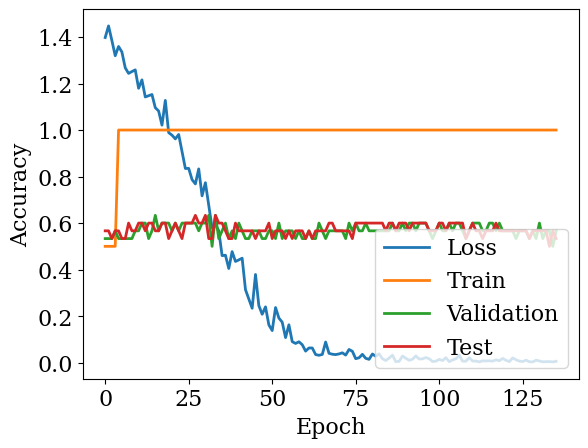

Best Validation Accuracy,  0.6333333333333333
Best Test Accuracy,  0.6333333333333333
Total epoch time:  43.12861394882202
0.6333333333333333 136


In [16]:
# args.log_info = True
# DATASET_NAME = 'karate'
# data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=True, split_no=1); print("")
# print(data)

# # (row, col) = data.edge_index
# # data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
# # data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
# # print(data)

# args.recompute = True


# if len(data.y.shape) > 1:
#     data.y = data.y.argmax(dim=1)        
#     num_classes = torch.max(data.y).item()+1
# else:
#     num_classes = dataset.num_classes

# if num_classes!= torch.max(data.y)+1:
#     num_classes = torch.max(data.y).item()+1
    
# # data.edge_index, _ = add_self_loops(data.edge_index)            
# # data.x = torch.cat((data.x, adj_feature(data)), dim=1)
# # if args.log_info == True:
# #     print(data.x.shape)

    
# # if DATASET_NAME in ['Cornell', 'cornell5']:
# #     data.edge_index, _ = add_self_loops(data.edge_index)            
    
# # if DATASET_NAME in ['Squirrel', 'Chameleon', 'amherst41',
# #                     'Cornell','cornell5', 'johnshopkins55']:
# #     data.x = torch.cat((data.x, adj_feature(data)), dim=1)
# #     if args.log_info == True:
# #         print(data.x.shape)


# best_acc, num_iteration, _ =  AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=150, train_neighbors=[8,4], test_neighbors=[8,4])
# print(best_acc, num_iteration)

# Batch Experiments

In [19]:
def batch_experiments(num_run=1):
    
    ALL_DATASETs= [
        "Cornell",
        "Texas",
        "Wisconsin",
        "reed98",
        "amherst41",
        "penn94",
        "Roman-empire",
        "cornell5",
        "Squirrel",
        "johnshopkins55",
        "AmazonProducts",
        "Actor",
        "Minesweeper",
        "Questions",
        "Chameleon",
        "Tolokers",
        "Flickr",
        "Yelp",
        "Amazon-ratings",
        "genius",
        "cora",
        "CiteSeer",
        "dblp",
        "Computers",
        "PubMed",
        "pubmed",
        "Reddit",
        "cora_ml",
        "Cora",
        "Reddit2",
        "CS",
        "Photo",
        "Physics",
        "citeseer"
    ]     
    
    ALL_DATASETs= [
        'cornell5',
    ]

    args.log_info = False
    
    filename = "Results/AGSGNN-NS-2.txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        print(DATASET_NAME, end=' ')
        
        
        result_file = open(filename,'a+')        
        result_file.write(f'{DATASET_NAME} ')
        result_file.close()
                
        accs = []
        itrs = []
                
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i)   
            
            #optional for making undirected graph
            (row, col) = data.edge_index
            data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
            data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
            
#             if data.num_nodes>100000:
#                 accs.append(-1)
#                 itrs.append(-1)
#                 break
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
                
            if data.num_nodes<100000:
                max_epochs = 150
            else:
                max_epochs = 20
            if DATASET_NAME in ['Squirrel', 'Chameleon','cornell5','penn94','johnshopkins55'
                               ]:
                data.x = torch.cat((data.x, adj_feature(data)), dim=1)
                if args.log_info == True:
                    print(data.x.shape)
                  
            accuracy, itr, _ = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[8,4], test_neighbors=[8,4])

            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        #print(accs, itrs)
        print(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file = open(filename,'a+')
        result_file.write(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()
                
batch_experiments(num_run=5)

cornell5 

KeyboardInterrupt: 

## View Learned Representation

In [ ]:
# if __name__ == '__main__':    
    
#     n=7
#     x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
#     y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
#     edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
#     edge_index = edge_index-1
    
#     mask = torch.zeros(n, dtype=torch.bool)
#     mask[[1,3]] = True
    
#     test_data = Data(x = x, y = y, edge_index = edge_index, train_mask = mask, test_mask = mask, val_mask = mask)    
#     print(test_data)
    
    
#     None

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

In [ ]:
# model.eval()
# #X = model(data.x.to(device),data.edge_index.to(device), data.weight.to(device))
# X = model(data.x.to(device),data.edge_index.to(device))
# X = X.detach().to('cpu')
# y = data.y.to('cpu')
# X.shape

In [ ]:
# plt.figure(figsize=(10, 10))

# # Create a t-SNE model with 2 components and a perplexity of 30
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate='auto', init='random')

# # Fit and transform the data to the 2D t-SNE space
# X_tsne = tsne.fit_transform(X)

# # Plot the data in the 2D t-SNE space, colored by class
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
# plt.show()